# Direct Problem
This section calculates the arrival-time anomalies $t_\gamma$ based on ray paths and slowness differences.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math 

x=np.linspace(0, 13, 14, dtype = int)
z=np.linspace(0,11, 12, dtype = int)

case = 1 #By plugging case = 1, the original problem with the medium is being addressed. Otherwise, the case of the delta function is investigated.

v0 = 5  #velocity where there is no medium
v_object = 5.2  #velocity where there is the medium


def v_diff(v0, v_object):      #function that computes the s(u) function for the arrival time anomaly tγ
    return (1/v_object)-(1/v0) #, which is non other that the time difference between two cases: medium is absent and medium is present

def time(d, s, case):  #function that computes the t_pure
    if case == 1: 
        if s == 1:  #s=1 means that the ray propagates from left to right
            if d < 6:
                Dt = 0  #Before the 6th detector, no ray passes through the medium. Therefore the time difference is zero.
            if d >= 6 and d < 9:  #From the 6th to the 9th detector, the ray passes through the medium for 1, 2 and 3 pixels respectively.
                Dt = v_diff(v0,v_object)*(d-5.)*np.sqrt(2) #mathematical expression that computes the aforementioned number of pixels 
            if d >=9 : #From the 9th to the 12th detector, the ray passes through the medium for 3 pixels for all detectors
                Dt = v_diff(v0,v_object)*3*np.sqrt(2)
        if s == 2: #s=1 means that the ray propagates from right to left
            if d >= 1 and d <= 3:
                Dt = v_diff(v0,v_object)*3*np.sqrt(2)
            if d > 3 and d < 6:
                Dt = v_diff(v0,v_object)*(6.-d)*np.sqrt(2)
            if d >= 6:
                Dt = 0 
    else: 
        if s == 1:
            if d == 8:
                Dt = v_diff(v0,v_object)*np.sqrt(2)
            else:
                Dt = 0
        if s == 2:
            if d == 3:
                Dt = v_diff(v0,v_object)*np.sqrt(2)
            else:
                Dt = 0 
    return Dt

T_g = []

for source in range (1,3):
    for detector in range (1,13):
        Time = time(detector, source, case)
        if source == 1:
            s = "left"
        else:
            s = 'right'
        print(f"Detector {detector}: Ray coming from the {s}: t_g = {Time:.3f}")
        T_g.append(Time)

Detector 1: Ray coming from the left: t_g = 0.000
Detector 2: Ray coming from the left: t_g = 0.000
Detector 3: Ray coming from the left: t_g = 0.000
Detector 4: Ray coming from the left: t_g = 0.000
Detector 5: Ray coming from the left: t_g = 0.000
Detector 6: Ray coming from the left: t_g = -0.011
Detector 7: Ray coming from the left: t_g = -0.022
Detector 8: Ray coming from the left: t_g = -0.033
Detector 9: Ray coming from the left: t_g = -0.033
Detector 10: Ray coming from the left: t_g = -0.033
Detector 11: Ray coming from the left: t_g = -0.033
Detector 12: Ray coming from the left: t_g = -0.033
Detector 1: Ray coming from the right: t_g = -0.033
Detector 2: Ray coming from the right: t_g = -0.033
Detector 3: Ray coming from the right: t_g = -0.033
Detector 4: Ray coming from the right: t_g = -0.022
Detector 5: Ray coming from the right: t_g = -0.011
Detector 6: Ray coming from the right: t_g = 0.000
Detector 7: Ray coming from the right: t_g = 0.000
Detector 8: Ray coming from 

# Discretization
Here, the 13x11 area is divided into 1x1 m squares, and ray paths are intersected with these cells.

In [2]:
###Medium position and G matrix###

def norm(A):                  #function that computes the L2-norm of a matrix A
    x=np.sqrt(np.sum(A**2))
    return x

A_medium = np.zeros((11,13))
if case == 1: 
    A_medium[1:8, 4:7] = 1.  
else:
    A_medium[2,5]=1.

G = np.zeros((24,143))  ##Constructing the G matrix## It constitutes all ray paths.
for i in range(1, 13):
    G[24-i] = np.eye(11, 13, 13-i).flatten()
    G[i-1]=np.fliplr(np.eye(11, 13, 13-i)).flatten() 
G = G * math.sqrt(2)

T_g = np.array([T_g])
T_g = T_g.T             #Calculating t_pure

# Inverse Problem Setup
This section sets up the inverse problem as a linear system $Gm = d$, where $m$ is the slowness anomaly vector, which is sought for.

# Adding Noise
Simulate realistic data by adding Gaussian noise to the computed anomalies.

In [3]:
###Noise and t_pure###

N = len(T_g)
mean = 0
std = norm(T_g)/(18*np.sqrt(N))

def get_noise(Number, m, std): #Function that computes the noise. Random numbers are being sampled from the normal distribution 
#with mean=0 and std=norm/18*sqrt(N), where N is the number of the data/measurements
    
    np.random.seed(42) 
    n = np.random.normal(m, std, Number) #random distribution
    n = np.array([n])
    n = n.T

    return n

noise = get_noise(N, mean, std)

Time_obs = T_g + noise #By adding the noise to t_pure we get t_observation, meaning our data for the inverse problem

# Tikhonov Regularization
Apply Tikhonov regularization to solve the inverse problem under uncertainty.

In [4]:
###Misfit and solution###

e = np.linspace(0.01, 10**(0), 1000)  #we vary the ε parameter and we calculate the misfit. For the case that the misfit becomes minimum, the respective parameter ε is the optimal one
misfit=np.zeros(len(e))

for i,j in enumerate(e):
    m=np.linalg.inv(G.T@G+np.identity(143)*(j**2))@G.T@Time_obs #computation of m for different paramaters ε via the Tikhonov algorithm
    misfit[i] = np.abs(norm(Time_obs-G@m)-Time_obs.shape[0]*np.std(noise)**2) #calculation of the misfit for different paramaters ε 

e_best = e[np.argmin(misfit)] #optimal ε is being acquired
m=np.linalg.inv(G.T@G+np.identity(143)*(e_best**2))@G.T@Time_obs #computation of m by inputing the optimal ε in the Tikhonov algorithm

m=m.reshape(11, 13) #reshaping m to visualize the results

# Visualization
Compare true and estimated models

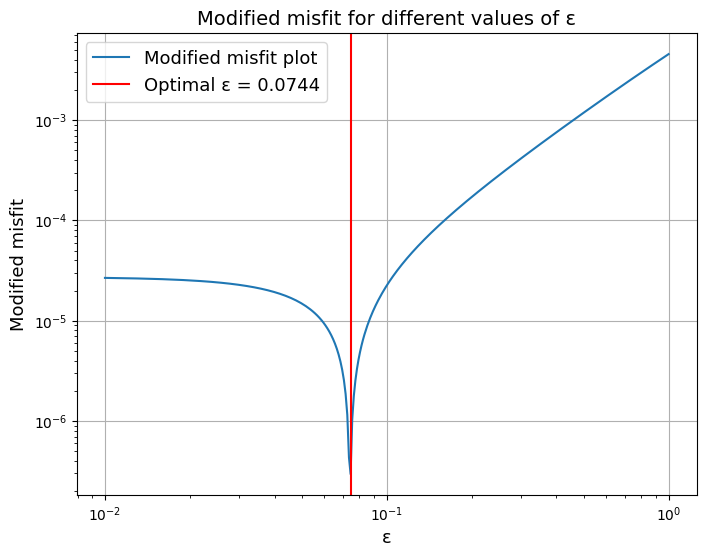

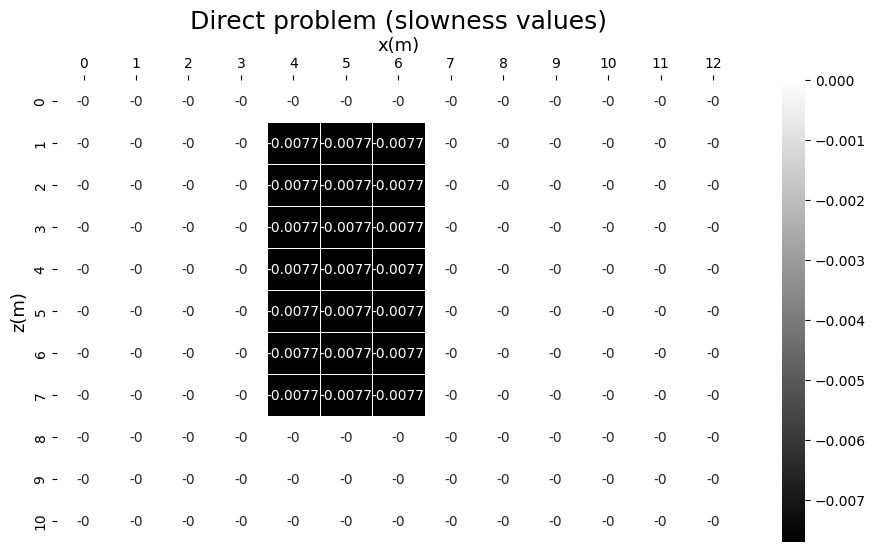

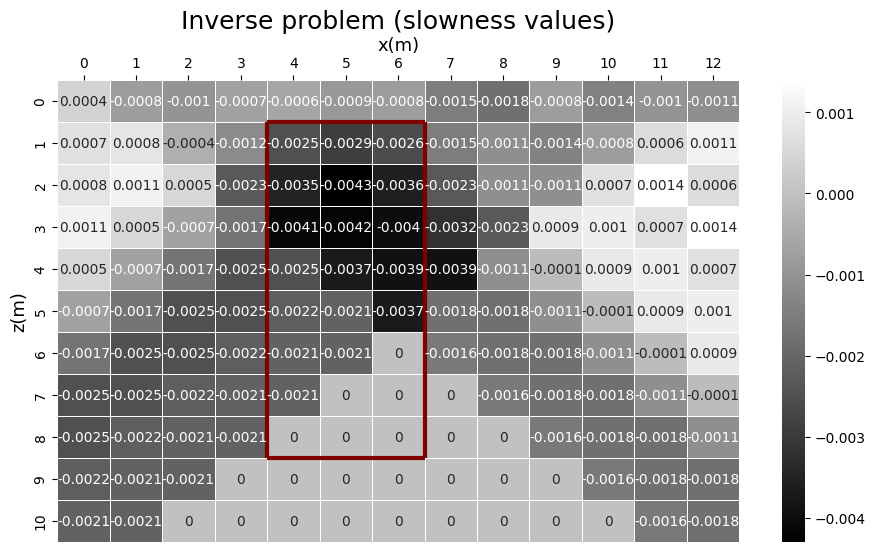

In [5]:
###Visualization###

fig, ax = plt.subplots(figsize = (8,6))
plt.plot(e, misfit, label = 'Modified misfit plot')
plt.title('Modified misfit for different values of ε', fontsize = 14)
plt.axvline(e_best,c='r', label = f'Optimal ε = {np.round(e_best,4)}')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Modified misfit', fontsize = 13)
plt.xlabel('ε', fontsize = 13)
ax.legend(fontsize = 13)
plt.grid()
plt.show()

fig, ax = plt.subplots(figsize=(11, 6))
sns.heatmap(np.round(A_medium*v_diff(v0, v_object), 4), annot = True, linewidth=0.5, cmap= "gist_gray", cbar=True)
plt.xlabel('x(m)', fontsize = 13)
plt.ylabel('z(m)', fontsize = 13)
# plt.title('Representation of the medium and slowness values from the direct problem')
plt.title('Direct problem (slowness values)', fontsize = 18)
ax.xaxis.set_label_position('top')
ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
plt.show()
fig.tight_layout()


fig, ax = plt.subplots(figsize=(11, 6))
sns.heatmap(np.round(m,4), annot=True, linewidth=0.5, cmap="gist_gray", cbar=True)
if case == 1:
    plt.hlines(1, xmin = 4, xmax = 7, color = [0.5, 0, 0], linewidth = 3)
    plt.hlines(9, xmin = 4, xmax = 7, color = [0.5, 0, 0], linewidth = 3)
    plt.vlines(4, ymin = 1, ymax = 9, color = [0.5, 0, 0], linewidth = 3)
    plt.vlines(7, ymin = 1, ymax = 9, color = [0.5, 0, 0], linewidth = 3)
else:
    plt.hlines(2, xmin = 5, xmax = 6, color = [0.5, 0, 0], linewidth = 3)
    plt.hlines(3, xmin = 5, xmax = 6, color = [0.5, 0, 0], linewidth = 3)
    plt.vlines(5, ymin = 2, ymax = 3, color = [0.5, 0, 0], linewidth = 3)
    plt.vlines(6, ymin = 2, ymax = 3, color = [0.5, 0, 0], linewidth = 3)

plt.xlabel('x(m)', fontsize = 13)
plt.ylabel('z(m)', fontsize = 13)
# plt.title('Representation of the medium and slowness values from the inverse problem')
plt.title('Inverse problem (slowness values)', fontsize = 18)
ax.xaxis.set_label_position('top') 
ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
plt.show()
fig.tight_layout()
